In [386]:
# !pip install gnss_lib_py

In [387]:
import numpy as np
import gnss_lib_py as glp
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import pandas as pd
import xarray as xarr
from scipy.ndimage import gaussian_filter1d
import math

https://drive.google.com/drive/folders/17vNrS_-Kq0msv2r9VHDkry3aEAxUcdAS

### Pseudorange computation

In [388]:
def compute_pseudoranges(raw_data):
    nanosecs_in_week = 604800e9
    speed_of_light = 299792458
    week_no = np.floor(-raw_data['FullBiasNanos']/nanosecs_in_week)
    corrected_rx_time = raw_data['TimeNanos'] + raw_data['TimeOffsetNanos']
    adjusted_rx_bias = raw_data['FullBiasNanos'] + raw_data['BiasNanos']
    rx_time_gps_frame = corrected_rx_time - adjusted_rx_bias
    rx_time_week_frame = rx_time_gps_frame - week_no * nanosecs_in_week
    rho_nanosecs = rx_time_week_frame - raw_data['ReceivedSvTimeNanos']
    rho_m = rho_nanosecs * speed_of_light/1e9
    return rho_m

In [389]:
# rover_path = './Oval/LongOvalLoop_gnss_log_2024_11_17_16_47_03.txt'
rover_path = './Oval/RoundLoop1_gnss_log_2024_11_17_16_52_31.txt'
base_path = './Oval/RoundLoop1_BaseStation_gnss_log_2024_11_17_16_52_30.txt'

In [390]:
rover_data = glp.AndroidRawGnss(input_path=rover_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)
rover_data['FullBiasNanos'] = rover_data['FullBiasNanos'] - 604800e9
rover_data['TimeNanos'] = rover_data['TimeNanos'] - 604800e9
offset_ms_rover = -145
offset_ms_base = -145
# offset_ms_base = 0.0
# offset_ms_rover = 0.0

base_data = glp.AndroidRawGnss(input_path=base_path,
                              filter_measurements=True,
                              measurement_filters={"sv_time_uncertainty" : 500.},
                              verbose=True)


offset_rover_data = rover_data.copy()
offset_base_data = base_data.copy()
offset_rover_data["gps_millis"] = rover_data["gps_millis"] + offset_ms_rover
offset_base_data["gps_millis"] = base_data["gps_millis"] + offset_ms_base

sv_time_uncertainty removed 1
sv_time_uncertainty removed 1


In [391]:
rover_data_gps_only = offset_rover_data.where('gnss_id', ('gps'), 'eq')
base_data_gps_only = offset_base_data.where('gnss_id', ('gps'), 'eq')

In [392]:
rover_rho = compute_pseudoranges(rover_data_gps_only)

In [393]:
def interpolate_base_values(rover_data_gps_millis, base_data_for_sat):
    '''
    rover_data_gps_millis: This is the GPS millis time for a single measurement in the rover data
    base_data_for_sat: This are all the measurements in the base data for a single satellite (i.e. the
                        sv_id and gnss_id have already been matched).

    Returns:
    Interpolated data: All the data columns in the base data interpolated to get values for the exact gps millis used
                       in the rover data.
    success: If interpolation was successful. If not, flag to indicate that we should throw out that data point.
    '''
    GPS_MILLIS_COL = -3
    upper_index = np.searchsorted(base_data_for_sat['gps_millis'], rover_data_gps_millis)
    base_data_array_ver = base_data_for_sat.array
    row_lower = base_data_array_ver[:, upper_index-1]
    row_higher = base_data_array_ver[:, upper_index]
    interpolated_data_arr = row_lower + (rover_data_gps_millis - row_lower[GPS_MILLIS_COL])/(row_higher[GPS_MILLIS_COL] - row_lower[GPS_MILLIS_COL]) * (row_higher - row_lower)
    interpolated_data_pd = pd.DataFrame(columns = base_data_for_sat.rows)
    interpolated_data_pd.loc[0] = interpolated_data_arr
    interpolated_data = glp.NavData()
    interpolated_data.from_pandas_df(interpolated_data_pd)
    # There might be more edge cases
    if (upper_index - 1) < 0:
        success = False
    else:
        success = True

    return interpolated_data, success

In [394]:
def compute_and_match_pr(rover_data, base_data):
    base_rho = []
    base_matched_data = []
    # time_tolerance = 5000
    for i in range(len(rover_data)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        a = base_data.where("sv_id", sv_id[i], "eq")
        b = a.where("gnss_id", gnss_id[i], "eq")
        c, success = interpolate_base_values(gps_millis[i], b)
        
        if not success:
            print('WARNING: UNSUCUESSFUL INTERPOLATION')
        rho_vals = compute_pseudoranges(c)
        base_rho.append(rho_vals)
        base_matched_data.append(c.array.squeeze())
    return base_matched_data, base_rho
matched_base_data, base_rho = compute_and_match_pr(rover_data_gps_only, base_data_gps_only)
base_rho = np.array(base_rho)

Rover data uses sv id of 2, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367294.0
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368294.0
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368294.0
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368294.0
Rover data uses sv id of 14, gnss id of gps, millis of 1415926368294.0
Rover data

### Load SLAC Data instead

In [395]:
# Load the .npz file
loaded = np.load("test_slac/extracted_data.npz")
slac_time = loaded['time']
slac_sv = loaded['sv']
slac_C1 = loaded['C1']
slac_P1 = loaded['P1']
slac_true_pos = loaded['true_pos']


In [396]:
# Convert to datetime
datetime_obj = [datetime.utcfromtimestamp(ts.astype('datetime64[s]').astype(int)) for ts in slac_time]
slac_millis_offset = -18135.0
# slac_millis_offset = 0.0
slac_gps_millis = np.array([glp.datetime_to_gps_millis(dt_now) for dt_now in datetime_obj]) + slac_millis_offset
print(slac_gps_millis)

[1.41592320e+12 1.41592321e+12 1.41592323e+12 ... 1.41600955e+12
 1.41600957e+12 1.41600958e+12]


/home/gigavoltflash/miniconda3/lib/python3.9/site-packages/gnss_lib_py/utils/time_conversions.py:586: RuntimeWarning:

No time zone info found in datetime, assuming UTC



In [397]:
def interpolate_slac_values(rover_data_gps_millis, slac_time, slac_C1):
    # assumes that slac time is in millis too
    upper_index = np.searchsorted(slac_time, rover_data_gps_millis)
    t0 = slac_time[upper_index-1]
    t1 = slac_time[upper_index]
    pr_t0 = slac_C1[upper_index-1]
    pr_t1 = slac_C1[upper_index]
    pr = pr_t0 + (rover_data_gps_millis - t0)/(t1 - t0) * (pr_t1 - pr_t0)
    return pr

# assumes that we're only using GPS for now
def compute_and_match_pr_slac(rover_data, slac_time, slac_C1, slac_sv):
    pr = np.zeros(len(rover_data))
    for i in range(len(rover_data)):
        sv_id = rover_data['sv_id']
        gnss_id = rover_data['gnss_id']
        gps_millis = rover_data['gps_millis']
        print('G{:02}'.format(sv_id[i]))
        print(f'Rover data uses sv id of {sv_id[i]}, gnss id of {gnss_id[i]}, millis of {gps_millis[i]}')
        sv_index = np.where(slac_sv == 'G{:02}'.format(sv_id[i]))[0][0]
        pr[i] = interpolate_slac_values(gps_millis[i], slac_time, slac_C1[:, sv_index])
    return pr
slac_pr = compute_and_match_pr_slac(rover_data_gps_only, slac_gps_millis, slac_C1, slac_sv)

G02
Rover data uses sv id of 2, gnss id of gps, millis of 1415926367294.0
G07
Rover data uses sv id of 7, gnss id of gps, millis of 1415926367294.0
G13
Rover data uses sv id of 13, gnss id of gps, millis of 1415926367294.0
G14
Rover data uses sv id of 14, gnss id of gps, millis of 1415926367294.0
G15
Rover data uses sv id of 15, gnss id of gps, millis of 1415926367294.0
G17
Rover data uses sv id of 17, gnss id of gps, millis of 1415926367294.0
G19
Rover data uses sv id of 19, gnss id of gps, millis of 1415926367294.0
G21
Rover data uses sv id of 21, gnss id of gps, millis of 1415926367294.0
G22
Rover data uses sv id of 22, gnss id of gps, millis of 1415926367294.0
G30
Rover data uses sv id of 30, gnss id of gps, millis of 1415926367294.0
G02
Rover data uses sv id of 2, gnss id of gps, millis of 1415926368294.0
G07
Rover data uses sv id of 7, gnss id of gps, millis of 1415926368294.0
G13
Rover data uses sv id of 13, gnss id of gps, millis of 1415926368294.0
G14
Rover data uses sv id of 

### Verifying that the rover is matched well to base measurements

(20000000.0, 25000000.0)

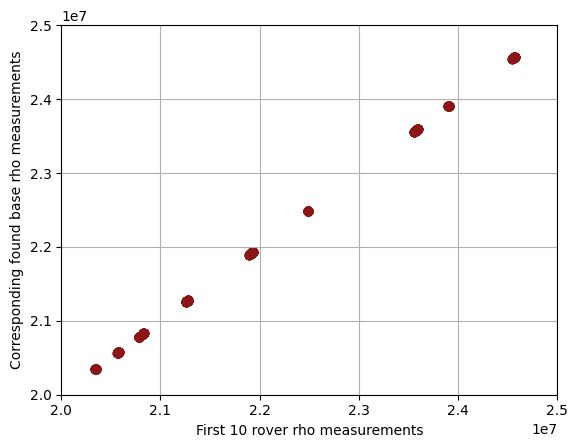

In [398]:
plt.scatter(rover_rho, base_rho)
plt.grid()
plt.xlabel('First 10 rover rho measurements')
plt.ylabel('Corresponding found base rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

(20000000.0, 25000000.0)

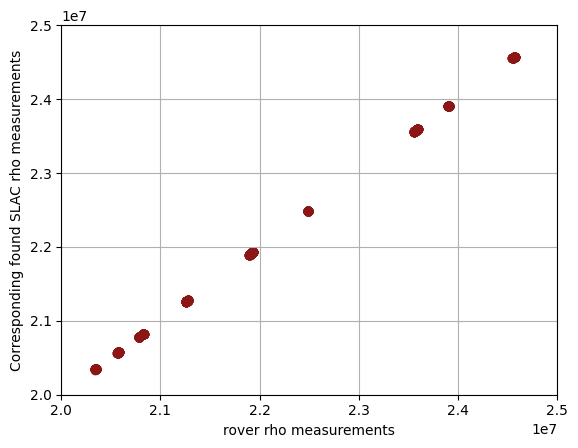

In [399]:
plt.scatter(rover_rho, slac_pr)
plt.grid()
plt.xlabel('rover rho measurements')
plt.ylabel('Corresponding found SLAC rho measurements')
plt.xlim(2e7, 2.5e7)
plt.ylim(2e7, 2.5e7)

In [400]:
timestamps = rover_data_gps_only['gps_millis']
base_timestamps = base_data_gps_only['gps_millis']
satellites = rover_data_gps_only['sv_id']
print(f'number of unique timesteps {len(np.unique(timestamps))}')

number of unique timesteps 75


### Calculate true ranges

In [401]:
BASE_STATION_LOCATION_1 = np.array([37.429711,-122.169381,25]).reshape(3, 1)
BASE_STATION_LOCATION_2 = np.array([37.4290631,-122.1723136,25]).reshape(3, 1) # multipath test

DURAND = np.array([[37.426906], [-122.173278], [21.010]]) 

In [402]:
gps_millis_column = -3
sv_id_column = 11
gnss_id_column = -13

In [403]:
matched_base_data_clean = np.zeros((len(matched_base_data),len(matched_base_data[0])))
for i in range(len(matched_base_data)):
    matched_base_data_clean[i, :] = matched_base_data[i]
    matched_base_data_clean[i, gnss_id_column] = 100.0

#### Old method using find_sv_pos

In [404]:
# ## Load the RinexNav data for that day
# rinex_nav_paths = glp.load_ephemeris(
#     "rinex_nav",
#     np.array(np.nanmin(matched_base_data_clean[:, gps_millis_column]),np.nanmax(matched_base_data_clean[:, gps_millis_column])),
#     verbose=True,
# )
# rinex_nav = glp.RinexNav(rinex_nav_paths, verbose=True)

In [405]:
GNSS_ID_FLOAT = 100.0
# def find_sv_pos(rinex, gnss_data_array):
#     """ finding sv position with ephemeris data FOR DURAND receiver"""
#     sv_id = gnss_data_array[:, sv_id_column]
#     gps_millis = gnss_data_array[:, gps_millis_column]
#     n = len(sv_id)
#     position_info = np.zeros((n, 3))
#     bias_info = np.zeros(n)
#     for i in range(n):
#         print(i)
#         sv_at_millis = glp.find_sv_states(gps_millis[i], rinex)
#         cropped_sv_at_millis = sv_at_millis.where('sv_id', sv_id[i], 'eq')
#         gnss_id_at_millis = cropped_sv_at_millis.where('gnss_id', ('gps'), 'eq')
#         position_info[i, 0] = np.mean(gnss_id_at_millis['x_sv_m'])
#         position_info[i, 1] = np.mean(gnss_id_at_millis['y_sv_m'])
#         position_info[i, 2] = np.mean(gnss_id_at_millis['z_sv_m'])
#         bias_info[i] = np.mean(gnss_id_at_millis['b_sv_m'])
#     return position_info, bias_info


In [406]:
# sv_pos, sv_bias = find_sv_pos(rinex_nav, matched_base_data_clean)
# sv_pos_base_data_gps_only, sv_bias_base_data_gps_only = find_sv_pos(rinex_nav, base_data_gps_only.array.T)
# sv_pos = find_sv_pos(rover_ephemeris, 6)
# true_ranges = distance_to_groundtruth()

#### New Method using add_sv_states_rinex

In [407]:
rover_with_sv_pos = glp.add_sv_states_rinex(rover_data_gps_only)

In [408]:
sv_pos = np.vstack((rover_with_sv_pos['x_sv_m'], rover_with_sv_pos['y_sv_m'], rover_with_sv_pos['z_sv_m'])).T
sv_bias = rover_with_sv_pos['b_sv_m']

In [409]:
rover_rho_corrected = rover_rho + sv_bias
base_rho_corrected = base_rho + sv_bias
slac_pr_corrected = slac_pr + sv_bias

### Actual dGNSS shit

In [410]:
def distance_to_groundtruth(sv_pos, ground_truth):
    """ calculate ground truth distance from SV to Durand receiver"""
    gt_ecef = glp.geodetic_to_ecef(ground_truth)
    distance = np.linalg.norm(sv_pos[:, :, None] - gt_ecef[None, :, :], axis=1)
    return distance

def correction(true_range, base_pseudorange, rover_pseudorange):
    """ true_range: ground truth distance from distance_to_groundtruth function
    base_pseudorange: pseudorange for base station
    pseudorange: pseudorange for phone """
    e = true_range - base_pseudorange
    adjusted_pseudorange = rover_pseudorange + e
    return adjusted_pseudorange

In [411]:
true_range = distance_to_groundtruth(sv_pos, BASE_STATION_LOCATION_1).flatten()
corrected_pseudorange = correction(true_range, base_rho_corrected, rover_rho_corrected)
# SLAC version
true_range_slac = np.linalg.norm(sv_pos.T - slac_true_pos[:, None], axis=0)
corrected_pseudorange_slac = correction(true_range_slac, slac_pr_corrected, rover_rho_corrected)

Text(0.5, 1.0, 'Phone base station')

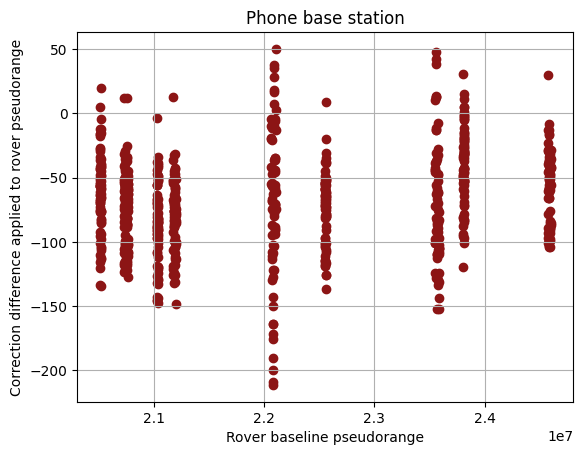

In [412]:
plt.scatter(rover_rho_corrected, corrected_pseudorange - rover_rho_corrected)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('Correction difference applied to rover pseudorange')
plt.grid()
plt.title('Phone base station')

Text(0.5, 1.0, 'DGNSS corrections using SLAC data')

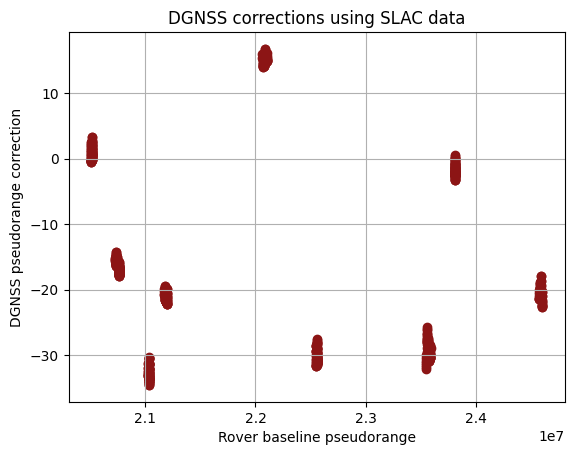

In [413]:
plt.scatter(rover_rho_corrected, corrected_pseudorange_slac - rover_rho_corrected)
plt.xlabel('Rover baseline pseudorange')
plt.ylabel('DGNSS pseudorange correction')
plt.grid()
plt.title('DGNSS corrections using SLAC data')

### Newton Raphson to solve for position

In [414]:
def newton_raphson(x0, bu_0, max_iterations, dataset):
    """
    Function description: perform newton raphson to compute position of observer based on available satellite
    data, stop function when we have updates in delta_x, delta_bu that are less than a centimeter,
    or hit maximum number of iterations

    Inputs:
    1) x_0: initial guess for position
    2) bu_0: initial guess for clock bias
    3) max_iterations: maximum number of iterations until covergence
    4) dataset_name: name of file to read in

    return: 
    1) optimized position
    2) optimized clock bias
    3) number of iterations until covergence
    """
    x_est = x0
    b_est = bu_0


    for i in range(max_iterations):

        # Get Geometry Matrix and deltas for rho
        geometry_matrix = []
        delta_rho = []
        for index, sat in dataset.iterrows():
            geometry_matrix.append(get_geometry_row(x_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))
            delta_rho.append(sat['corr_pr_m'] - get_theoretical_pseudoranges(x_est, b_est, sat['x_sv_m'], sat['y_sv_m'], sat['z_sv_m']))

        # Convert into matricies to make it easier to use numpy functions
        geometry_matrix = np.array(geometry_matrix)
        delta_rho = np.array(delta_rho)

        # Update the deltas
        delta_x, delta_bu = newton_raphson_step(geometry_matrix, delta_rho)
        x_est = np.add(x_est, delta_x)
        b_est = b_est + delta_bu
    
        if True: #i%10 == 0:
            print("round: ",i+1)
            print("x_est: ", x_est)
            print("b_est: ", b_est)

        if delta_x[0] < 0.01 and delta_x[1] < 0.01 and delta_x[2] < 0.01 and delta_bu < 0.01:
            break
    
    
    print("round: ",i+1)
    print("FINAL - x_est: ", x_est)
    print("FINAL - b_est: ", b_est)
    return x_est


def get_geometry_row(x_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current guess for current position estimate 
    2) x_sv_m: a set for satellite position x
    3) y_sv_m: a set for satellite position y
    4) z_sv_m: a set for satellite position z


    return: 
    1) Geometry Matrix G (first 3 columns unit vector)
    """

    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)

    return ([-x/magnitude, -y/magnitude, -z/magnitude, 1])



def get_theoretical_pseudoranges(x_est, b_est, x_sv_m, y_sv_m, z_sv_m):
    """
    Function description: Compute each row for the geometry matrix given a satellite position and
    current guess for position estimate

    Inputs:
    1) x_est: current position estimate 
    2) b_est: current clock bias estimate 
    3) x_sv_m: a set for satellite position x
    4) y_sv_m: a set for satellite position y
    5) z_sv_m: a set for satellite position z

    return: 
    1) Theoretical pseudorange measurement vector
    """


    x = x_sv_m - x_est[0]
    y = y_sv_m - x_est[1]
    z = z_sv_m - x_est[2]

    magnitude = np.sqrt((x)**2 + (y)**2 + (z)**2)
    b_k = 0 # assume its zero for all satellites, already corrrected for in data

    return magnitude + b_est - b_k

def newton_raphson_step(G,delta_rho):
    """
    Function description: Take one step of newton-raphson optimization, compute update of 
    delta_x and delta_bu

    Input:
    1) G: geometry matrix
    2) delta_rho: difference of theoretical and measured pseudoranges 

    return:
    1) delta_x
    2) delta_bu
    """
    G_t = G.transpose()
    deltas = np.matmul(np.matmul(np.linalg.inv(np.matmul(G_t, G)),G_t),delta_rho)

    delta_x = deltas[0:3]
    delta_bu = deltas[3]

    return delta_x, delta_bu

In [415]:
def generate_lat_lon(millis, sv_pos, pr_vals, name):
    unique_millis = np.unique(millis)
    pos_ls = []
    # batch pr with same millis
    for i in range(len(unique_millis)):
        mask = millis == unique_millis[i]
        pr = pr_vals[mask]
        x = sv_pos[mask, 0]
        y = sv_pos[mask, 1]
        z = sv_pos[mask, 2]

        # Create DataFrame using the arrays
        df = pd.DataFrame({
            'x_sv_m': x,
            'y_sv_m': y,
            'z_sv_m': z,
            'corr_pr_m': pr
        })

        df_cleaned = df.dropna()
        pos = newton_raphson([0,0,0],0,30,df_cleaned)

        print("Lat/Long Version: ",glp.ecef_to_geodetic(pos))

        pos_ls.append(glp.ecef_to_geodetic(pos))

    pos_array = np.array(pos_ls)
    final_data = glp.NavData()
    final_data[f'lat_{name}_deg'] = pos_array[:,:,0]
    final_data[f'lon_{name}_deg'] = pos_array[:,:,1]
    return final_data

In [416]:
dgnss = generate_lat_lon(timestamps, sv_pos, corrected_pseudorange, 'dgnss')
rover = generate_lat_lon(timestamps, sv_pos, rover_rho_corrected, 'rover')
base = generate_lat_lon(timestamps, sv_pos, base_rho_corrected, 'base_phone')
slac = generate_lat_lon(timestamps, sv_pos, slac_pr_corrected, 'slac')
dgnss_slac = generate_lat_lon(timestamps, sv_pos, corrected_pseudorange_slac, 'dgnss_slac')
# base_gps_only = generate_lat_lon(base_timestamps, sv_pos_base_data_gps_only, base_data_gps_only['raw_pr_m'])

round:  1
x_est:  [-3190251.46000564 -5150262.52571281  4662429.3395064 ]
b_est:  1319727.0499614729
round:  2
x_est:  [-2713026.30335296 -4320264.15911946  3883488.82699647]
b_est:  45363.0782316688
round:  3
x_est:  [-2700013.24814127 -4292671.95980865  3855425.64183003]
b_est:  67.85687379649607
round:  4
x_est:  [-2700000.91523972 -4292640.69939595  3855392.07507401]
b_est:  17.228421068541806
round:  5
x_est:  [-2700000.91522672 -4292640.69935702  3855392.07503031]
b_est:  17.228356077041397
round:  5
FINAL - x_est:  [-2700000.91522672 -4292640.69935702  3855392.07503031]
FINAL - b_est:  17.228356077041397
Lat/Long Version:  [[  37.42974183 -122.16922257   28.32529744]]
round:  1
x_est:  [-3190237.71452548 -5150238.18982529  4662397.64070377]
b_est:  1319630.8263938327
round:  2
x_est:  [-2713033.29614522 -4320269.26702782  3883497.27444971]
b_est:  45309.45319261844
round:  3
x_est:  [-2700022.55153444 -4292680.49369482  3855438.92180207]
b_est:  20.187089294828183
round:  4
x_es

In [417]:
glp.ecef_to_geodetic(slac_true_pos)

array([[  37.41651399, -122.2042489 ,   64.21140531]])

In [418]:
true_pos_navdata = glp.NavData()
true_pos_navdata['lat_true_slac_deg'] = glp.ecef_to_geodetic(slac_true_pos).squeeze()[0]
true_pos_navdata['lon_true_slac_deg'] = glp.ecef_to_geodetic(slac_true_pos).squeeze()[1]

In [419]:
a = []
# a.append(base)
# a.append(rover)
# a.append(dgnss)
a.append(slac)
a.append(dgnss_slac)
a.append(true_pos_navdata)
glp.plot_map(*a)
# glp.plot_map(rover)
# glp.plot_map(base_gps_only)



In [420]:
rover_fixed = glp.AndroidRawFixes(rover_path)

In [421]:
glp.plot_map(rover_fixed)

In [422]:
# Haversine formula to calculate the distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

# Function to calculate the total path length (sum of distances between consecutive points)
def calculate_path_length(coords):
    total_distance = 0
    for i in range(len(coords) - 1):
        lat1, lon1 = coords[i]
        lat2, lon2 = coords[i + 1]
        total_distance += haversine(lat1, lon1, lat2, lon2)
    return total_distance

def gaussian_smooth_coordinates(coords, sigma=1):
    # Convert to numpy array for easier handling
    coords = np.array(coords)
    
    # Apply Gaussian smoothing to latitudes and longitudes
    smoothed_lats = gaussian_filter1d(coords[:, 0], sigma=sigma)
    smoothed_lons = gaussian_filter1d(coords[:, 1], sigma=sigma)
    
    # Return smoothed coordinates as a list of tuples
    smoothed_coords = list(zip(smoothed_lats, smoothed_lons))
    
    return smoothed_coords

def smoothing_and_path_length(positions, name):
    # Example coordinates
    coordinates = positions.array.T

    smoothed_coordinates_gaussian = gaussian_smooth_coordinates(coordinates, sigma=1.5)

    # Example coordinates (latitude, longitude) - Replace with your own list
    coordinates = smoothed_coordinates_gaussian

    # Calculate the total path length
    total_distance = calculate_path_length(coordinates) * 1000

    # Print the total path length
    print(f"Total path length: {total_distance:.2f} meters")

    a = np.array(smoothed_coordinates_gaussian)
    final_data = glp.NavData()
    final_data[f'lat_{name}_deg'] = a[:,0]
    final_data[f'lon_{name}_deg'] = a[:,1]

    return final_data

In [424]:
smoothed_ls = []
smoothed_dgnss = smoothing_and_path_length(dgnss_slac, 'dgnss_slac')
smoothed_rover = smoothing_and_path_length(rover, 'rover')
smoothed_ls.append(smoothed_dgnss)
smoothed_ls.append(smoothed_rover)

glp.plot_map(*smoothed_ls)

Total path length: 129.16 meters
Total path length: 128.47 meters
